## Sampling
In practice, we will work with digital audio, meaning that we need to discretize our audio signal in time and amplitude. In this notebook, we discuss discretization in time - sampling. This has some really fundamental consequences on the bandwidth of the sampled signal, and if we don't do it right, we can end up with irreversible distortions. Sampling the starting point for any type of signal processing we want to do, so it's important we have a good understanding of it. As usual, there'll be some interactive plots/examples to help us along. 

In [ ]:
# Run this cell first to import libraries as usual. We'll need some functions to help import wav files.
%pip install ipympl
import numpy as np 
import matplotlib
if not hasattr(matplotlib.RcParams, "_get"):
    matplotlib.RcParams._get = dict.get
from scipy import signal
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import IPython
from IPython.display import Audio
from ipywidgets import interact # interactive plots
import io
from scipy.io import wavfile
from pyodide.http import pyfetch
%matplotlib ipympl

# Custom formatting function
def format_float(value):
    return f'{value:.6f}'  # Format value to display four decimal places

# function for importing wav files 
whistle_24k = "https://raw.githubusercontent.com/randyaliased/acspjbook/main/book/audio/whistle_24k.wav"
whistle_3k = "https://raw.githubusercontent.com/randyaliased/acspjbook/main/book/audio/whistle_3k.wav"

async def read_wav_from_url(url):
    response = await pyfetch(url)
    wav_bytes = await response.bytes()  # get raw binary
    fs, data = wavfile.read(io.BytesIO(wav_bytes))

    # convert to float in [-1, 1]
    if np.issubdtype(data.dtype, np.integer):
        max_val = np.iinfo(data.dtype).max
        data = data.astype(np.float32) / max_val
    else:
        data = data.astype(np.float32)  # already float
    
    return data, fs
      
  
  

### Going digital

Up until this point, although not explicitly stating it, we have been working with continuous-time signals (analog signals). These are signals for which at any instance in time (literally any), we know its ampltidue. When we record analog audio signals (e.g., someone singing) with a microphone, the sound is converted from an acoustic pressure to an electrical signal. At this point, the electrical signal is still analog and all the microphone has done is an acoustic to electrical signal conversion. In order to digitize this electrical representation of the sound, the electrical signal is then fed through an [analog to digital converter (ADC)](https://en.wikipedia.org/wiki/Analog-to-digital_converter). ADCs are typically integrated circuits and are core components of soundcards, whether that be your computer's internal soundcard or an external audio interface (e.g., [Focusright Scarlett](https://www.thomann.co.uk/focusrite_scarlett_2i2_4th_generation.htm)). ADCs accomplish two tasks: (i) discretization of the time base of the signal and (ii) discretization of the amplitude. 

For the task of discretizing in time, we *sample* the signal in time by taking snapshots of the signal at specific instances in time at a fixed rate. We can think of this as a switch that is repeatedly opening and closing at a fixed rate (number of times the switch closes per second). At the points in time when the switch is closed, we record the amplitude of the analog signal. So incomparison to a continuous-time signal, we now have a discrete time signal as we only have information at specific instances in time, and because the switch operated at a fixed rate, the time period in between the discrete time instances is constant. 

As the ADC also operates with a specific number of bits (e.g. 16-bit, 32-bit), the amplitude of the signal is also discretized, i.e., the amplitude must correspond to a speicfic level defined by the bit sequence. So for instance in a 2-bit recording, there are 4 discrete levels: 00, 01, 10, or 11. In general for an n-bit system, there are $2^{n}$ discrete levels, where higher bits allow for increased resolution. The amplitude that was captured at the discrete time instances must be snapped to one of these discrete levels. There are several issues to consider in this step of amplitude discretization, particularly [quantization](https://en.wikipedia.org/wiki/Quantization_(signal_processing)), but we will keep that for another notebook. Nevertheless, with both the time and amplitude discretization by the ADC, we obtain a digital audio signal, which we can manipulate with our computers. 

### Time discretization

Now that we have the general analog to digital audio conversion process in mind, let's go into more detail on the time discretization aspect, which we refer to as **sampling**. The key factor to consider in sampling is the **sampling frequency** (also called sample rate), which we will denote as $f_{s}$ and has the units of Hz (or 1/seconds). This corresponds to how fast we are opening and closing that "switch" to take snapshots of the signal, i.e., the number of times the switch closes per second, hence the unit of Hz. We refer to the time period in between the discrete time samples as the **sampling period**, $T_{s}$ with units of seconds. The sampling frequency and sampling period are therefore related by the formula,  $f_{s} = 1/T_{s}$.

In continuous-time, we mathematically represented signals as $y(t)$, a function of continuous time, $t$. With discrete-time signals, we need to change this representation. A simple way to do this to substitute $t = n.T_{s}$ for $n = 0, 1, 2, \dots$. With a fixed value of $T_s$, $n.T_{s}$ for $n = 0, 1, 2, \dots$ defines a number of discrete time instance for which we will have the corresponding amplitude values. As $T_{s}$ notation is a bit cumbersome to carry around, this is dropped in much of the literature, and the discrete-time signal is simply represented as $y[n]$ for $n = 0, 1, 2, \dots$, with the $T_s$ understood. In summary, our mathematical representation for discrete-time signals is (with a known $f_s$ or $T_s$):

$$\begin{align}
y(t) &\rightarrow y[n.T_{s}] \rightarrow y[n] \hspace{0.3cm} \text{for} \hspace{0.1cm} n = 0, 1, 2, \dots
\end{align}$$

Note our use of square brackets for the discrete-time signals, a common way to distinguish continuous-time and discrete-time signals.

Let's consider a simple sinusoid of 100 Hz as our continuous-time signal, and change $T_s$ to see the impact on what the discrete representation of the signal looks like. In the plot below the red signal represents the continuous-time signal and the blue dots represent the discrete-time version of the signal. 

In [ ]:
# "Continuous-time signal"
f = 100 # Frequency (Hz)
Tend = 0.1
Ts_c = 0.0001 # Sampling period (s)
tt_c = np.arange(0,Tend+Ts_c,Ts_c) # range of times to plot on x-axis
yy_c = np.cos(2*np.pi*f*tt_c) 


fig, axes = plt.subplots(figsize=(7, 3)) 
line, = axes.plot([],[],'-o', label='Discrete-time signal, y[n]')
axes.plot(tt_c, yy_c,color='red', label='Continuous-time signal, y(t)')
axes.set_ylabel('Amplitude', color='k')
axes.set_xlabel('Time (s)', color='k')
axes.grid()
axes.legend(loc='lower right')



# Create the interactive plot
def update(Ts = 0.0004):
    
    fs = 1/Ts # Sampling Frequency (Hz)
    tt = np.arange(0,Tend+Ts,Ts) # range of times to plot on x-axis
    yy = np.cos(2*np.pi*f*tt) 
    fig.canvas.draw_idle()
    line.set_data(tt, yy)
    
    print('Signal Frequency = '+str(f)+' Hz')
    print('Sampling Period, Ts = '+str(np.round(Ts,decimals=4))+' s')
    print('Sampling Frequency = '+str(np.round(fs,decimals=2))+' Hz')
    
print('Change the sampling period to see the impact')
interact(update, Ts = (0.0001,0.01,0.0001), format=format_float);

NameError: name 'np' is not defined

### Nyquist-Shannon sampling theorem 

One thing we can see is that as we increase $T_{s}$, i.e., if there is greater temporal spacing between our discrete samples, or if we were opening and closing the switch at a slower rate, the discrete representation becomes a poorer representation of the true continuous time signal. In fact we even see as $f_{s}$ reaches some value, it looks like the discrete time signal is of a lower frequency than the true 100 Hz signal - this is what we call **aliasing**!.

The **Nyquist-Shannon sampling theroem** gives us the condition under which we avoid this. In fact, if $f_{s}$ is above a certain threshold frequency, then we are guaranteed to have all of the information about the signal. The Nyquist-Shannon sampling theroem states that:

**The sampling frequency, $f_{s}$, must be greater than or equal to twice the bandwidth, $B$ (Hz) of the signal you are attempting to sample, i.e. $f_{s} \geq 2B$**.

Let's see the consequences of all of this and then try to understand why it's the case. 

To demonstrate this, I typically record a whistle going up in frequency and at different sample rates. This is the [aliasing whistle demo](https://github.com/randyaliased/acs-sp-demos/blob/main/01_Aliasing_Whistle_Demo.ipynb). Unfortunately these online Jupyter notebooks do not allow for recording, so I'll simply show the results below. I encourage you to download the demo though as it's alot more fun and you can try it with different types of signals.

In the following, the whistle I've recorded goes up to around $2$ kHz. Because this is a (more or less) pure tone, its bandwidth, $B$ is increasing over time until eventually  $B ~= 2$ kHz. I've recorded the whistle with $f_s = 24$ kHz, so we're not violating the Nyquist-Shannon sampling theroem, i.e., $f_{s} \geq 2B$. Let's look at the waveforms recorded and its
[spectrogram](https://randyaliased.github.io/acspjbook/main/fundamental/08_Time_Freq_Analysis.html) to observe the time-frequency content.

Data shape:  (72000, 1)
Whistle sampled at 24 kHz:


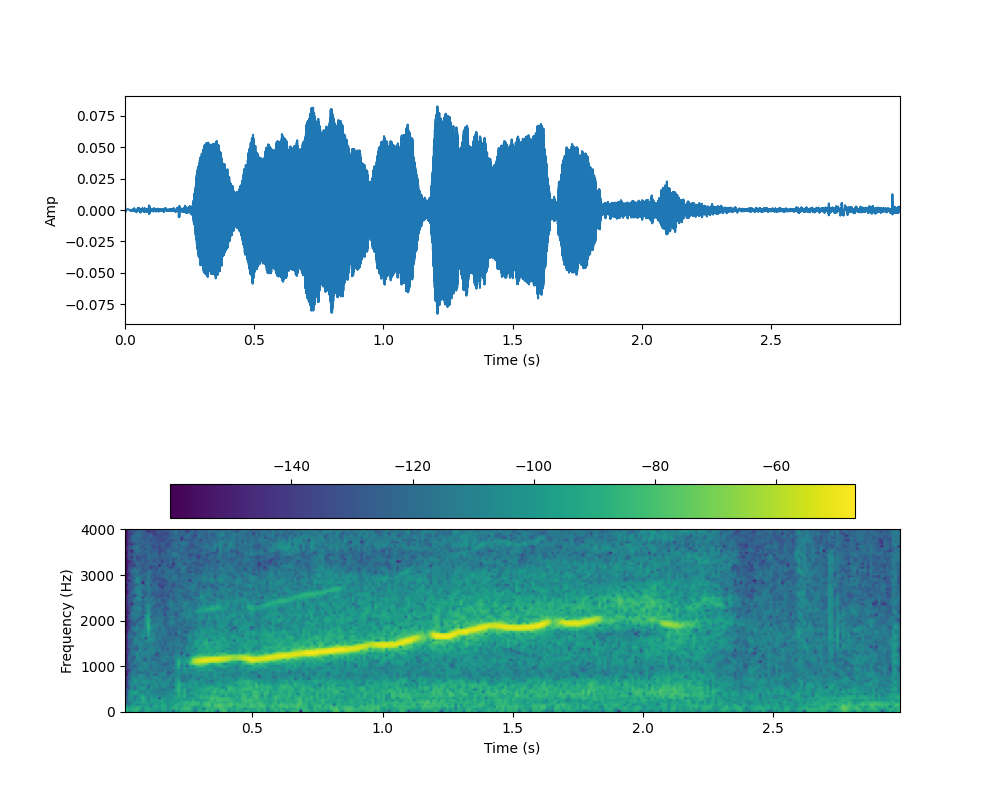

In [ ]:
whistle, fs = await read_wav_from_url(whistle_24k)
t = np.arange(0,len(whistle),1)*(1/fs) # time vector    

print("Data shape: ", whistle.shape)
print("Whistle sampled at 24 kHz:")
IPython.display.display(Audio(whistle.T, rate=fs))

# Creating the time vector
dt = 1/fs           
N = len(whistle) 
time = np.arange(0,N*dt,dt)  


fig, axes = plt.subplots(2, 1) 
fig.subplots_adjust(hspace=0.7) # spacing between figures

axes[0].plot(time,whistle)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amp')
axes[0].set_xlim(time[0],time[-1])

# Computing the spectrogram. We use the package signal which has a spectrogram function
nfft = 512         # number of points for the FFT 
noverlap = nfft/2  # Spectrogram overlap (make it 50 %)

# Compute the spectrogram. We set the mode to obtain the magnitude, 
# i.e absolute magnitude of the short-time Fourier transform (STFT) coefficients.
# Note that we are not concerned with the exact magnitude, i.e. sound pressure level of the signal
f_sg, t_sg, Z_mag = signal.spectrogram(whistle, fs=fs,nperseg=nfft,window='hann',mode='magnitude',noverlap=noverlap)
Z_dB = 10*np.log10(Z_mag**2 + 1e-16) # convert the magnitude to dB


# This is just some extra parameters for the imshow function, which allows you to plot a spectrogram
# The extent parameter is defining the corners of the image
extent = t_sg[0], t_sg[-1], f_sg[0], f_sg[-1]  # this defines the 4 corners of the "image"

sp = axes[1].imshow(Z_dB, origin='lower',aspect='auto',extent=extent)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_ylim(0,4000)   # Adjust this range if your whistle goes higher!
cb = plt.colorbar(sp,ax=[axes[1]],location='top')
plt.show()


### The perils of aliasing

Okay so that has given us a fairly accurate representation of the signal. What you see in the spectrogram is the brightest area corresponding to the highest acoustic pressures recorded. You will perhaps also see changing frequency content of the whistle signal, which has been captured accurately. Admittedly, this is more intuitive when you actually record the signal yourself because the sound of the recorded signal sounds like the sound you produced.

In the following, I've repeated the same whistle with increasing bandwidth until  $B ~= 2$ kHz, but now recorded it at a lower sampling frequency of $f_s = 3$ kHz. In this case, we are in direct violation of the Nyquist-Shannon criterion, i.e., $f_{s} < 2B$. Let's hear what the recorded signal sounds like. 

The key take away is that if you sampled at too low of a sampling frequency, the signal content that you think might be there is actually not true, but an artifact created by aliasing! So we need to be careful! How? Luckily, in practice, many ADCs have an analog low pass filter, which pre-filters the analog electrical signal so its bandwidth, $B < f_{s}/2$ to guarantee that the Nyquist-Shannon criterion is satisfied before sampling. This type of analog low pass filter is called an anti-aliasing filter.

Data shape:  (9000, 1)
Whistle sampled at 4 kHz:


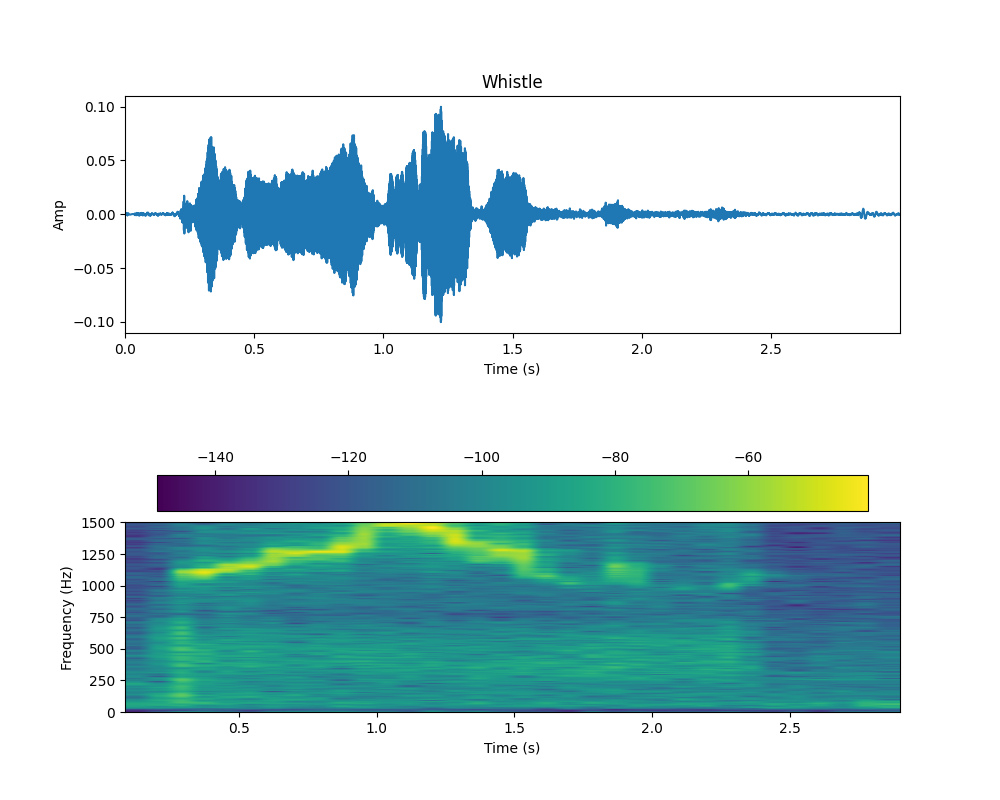

In [ ]:
whistle, fs = await read_wav_from_url(whistle_3k)
t = np.arange(0,len(whistle),1)*(1/fs) # time vector

print("Data shape: ", whistle.shape)
print("Whistle sampled at 3 kHz:")
IPython.display.display(Audio(whistle.T, rate=fs))

# Need to redefine the time vector since we use a different fs!
dt = 1/fs           
N = len(whistle) 
time = np.arange(0,N*dt,dt)  


fig, axes = plt.subplots(2, 1) 
fig.subplots_adjust(hspace=0.6) # spacing between figures

axes[0].plot(time,whistle)
axes[0].set_title('Whistle')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amp')
axes[0].set_xlim(time[0],time[-1])

# Computing the spectrogram. We use the package signal which has a spectrogram function
nfft = 512         # number of points for the FFT 
noverlap = nfft/2  # Spectrogram overlap (make it 50 %)

# Compute the spectrogram. We set the mode to obtain the magnitude, 
# i.e absolute magnitude of the short-time Fourier transform (STFT) coefficients.
# Note that we are not concerned with the exact magnitude, i.e. sound pressure level of the signal
f_sg, t_sg, Z_mag = signal.spectrogram(whistle, fs=fs,nperseg=nfft,window='hann',mode='magnitude',noverlap=noverlap)
Z_dB = 10*np.log10(Z_mag**2) # convert the magnitude to dB


# This is just some extra parameters for the imshow function, which allows you to plot a spectrogram
# The extent parameter is defining the corners of the image
extent = t_sg[0], t_sg[-1], f_sg[0], f_sg[-1]  # this defines the 4 corners of the "image"

sp = axes[1].imshow(Z_dB, origin='lower',aspect='auto',extent=extent)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')
cb = plt.colorbar(sp,ax=[axes[1]],location='top')
plt.show()





### But why did aliasing occur?

In the above figure, you may have noticed that the whistle sound seemed to have "bounced off" a frequency of $f_s/2$ and started descended downwards instead of upwards. We refer to the frequency $f_s/2$ as the **Nyquist frequency**. But why exactly did this happen? We can explain this mathematically, but perhaps it's a bit more intuitive with the following interactive plot. In the following, I've created a signal with two sinusoids at frequencies $50$ Hz and $75$ Hz, hence the bandwidth, $B = 75$ Hz. You will see two columns of figures: the left hand column (LHC) relates to the time domain and on the right hand column (RHC), the frequency domain.

In the time domain, we can think of sampling as a process that involves the multiplication of the continuous time signal (first figure on the LHC) an impulse train, i.e., a series of impulses spaced by $T_s$ seconds (second figure on the LHC). The result is the discrete time/sampled signal in the last figure of the LHC.

In the RHC, the first figure shows the magnitude spectrum of the continuous time signal. We are only showing the positive side of the spectrum, but recall that since the spectrum is symmetric around 0 Hz, there is a corresponding negative part, which is simply the magntiudes shown reflected around the y-axis. 

The second figure in the RHC is the Fourier transform of the impulse train - which is in fact another impulse train, but the samples are now separated by $f_s = 1/T_s$ Hz. In the frequency domain, a multiplication in the time domain corresponds to a convolution in the frequency domain. We'll get to convolution later, all that's important to know for now is that the result of this operation is that the magnitude spectrum of the continuous time signal (and remember it was symmetric around 0 Hz) is repeated at integer multiples of $f_s$, i.e, at each of those impulses in the frequency domain impulse train. We call these repetitions **frequency replicas** or images. 

In the interactive plot, what you will see is that as you decrease $f_{s}$ (increase $T_{s}$), the impulses on the RHC get closer together, and consequently, the frequency replicas begin to creep up unto the original bandwidth of the continuous-time signal. It eventually reaches a point where the frequency replicas begin to overlap with the original frequency spectrum, i.e., **aliasing** would have now occurred and as you previously heard, this is unfortunately an irreversible distortion. 

Let's mathematically define that. Recall that the bandwidth of our signal is given by $B$. If we observe the first set of frequency replicas around $f_s$, we can represent the lowest frequency in that set as $f_s - B$. In the figure, this is the frequency of the first component ("arrow") that you see above $B$ (i.e., the 75 Hz component of the continuous-time signal). The overlap of these two components occurs when:

$$\begin{align}
f_s - B &<= B \\
    f_s &<= 2B
\end{align}$$

This is why in the whistle example with $f_s = 3$ kHz, as the bandwidth of the whistle was changing from $B ~= 1.5$ kHz to $B ~= 2$ kHz, the aliased component $f_s - B$ (ranging from $1.5$ kHz to $1$ kHz) is what we heard instead. This formulation also makes it evident why the Nyquist-Shannon thereom requires that $fs \geq 2B$, i.e., the sampling frequency must be greater than or equal to the bandwidth of the continuous-time signal.


Change the sampling period to see the impact


NameError: name 'format_float' is not defined

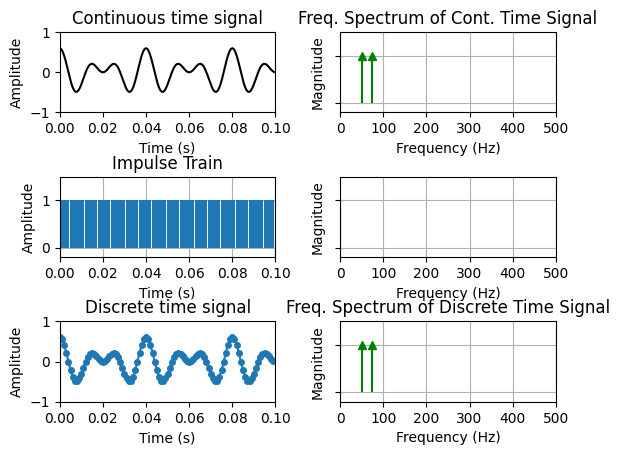

In [ ]:
# A few functions...

# Make a simple signal 
def make_signal(f1, f2, time):
    y = 0.3*np.cos(2*np.pi*f1*time) + 0.3*np.cos(2*np.pi*f2*time)
    return y

# This is a helper function to get data to plot for the freq. spectrum of discrete signal
def get_freq_rep(fs, freq_in):
    data = []
    for n in np.arange(-10,  11, 1):
        if n!=0:
            offset = n*fs
            data.append(offset+freq_in)    
    return np.array(data).flatten()


Ts_min = 0.001 # Sampling period (s) (starting value, we will change later)
fs_max = 1/Ts_min
T = 0.1 # total time (seconds)
t = np.arange(0, T, Ts_min)
imp = np.ones(len(t))

# Input Signals
f1 = 50 # Frequency (Hz)
f2 = 75

t_cont = np.arange(0, T, (1/(f2*20))) # make a time with a small sampling period to act as our "continuous signal"
y_cont = make_signal(f1, f2, t_cont)
y_disc = make_signal(f1, f2, t)

fig, axes = plt.subplots(3,2)
fig.subplots_adjust(wspace=0.3, hspace=1)

# "Continuous time" signal
axes[0,0].plot(t_cont,y_cont, color='k')
axes[0,0].set_ylabel('Amplitude', color='k')
axes[0,0].set_xlabel('Time (s)', color='k')
axes[0,0].set_title('Continuous time signal')
axes[0,0].set_xlim([0, T])
axes[0,0].set_ylim([-1, 1])

# Time-Domain Impulse Train
markers, = axes[1,0].plot([],[],ls="none",marker="o")
verts=np.c_[t, np.zeros_like(t), t, imp].reshape(len(t),2,2)
col = LineCollection(verts)
axes[1,0].add_collection(col)
axes[1,0].set_ylabel('Amplitude', color='k')
axes[1,0].set_xlabel('Time (s)', color='k')
axes[1,0].set_title('Impulse Train')
axes[1,0].set_xlim([0, T])
axes[1,0].set_ylim([-0.2, 1.5])
axes[1,0].grid()

# Discrete time signal

line, = axes[2,0].plot(t,y_disc,'-o',markersize=4)
axes[2,0].set_ylabel('Amplitude', color='k')
axes[2,0].set_xlabel('Time (s)', color='k')
axes[2,0].set_title('Discrete time signal')
axes[2,0].set_xlim([0, T])
axes[2,0].set_ylim([-1, 1])




# Frequency Spectrum of continuous time data
freq_input = np.array([-f2, -f1, f1, f2])
freq_input_data = np.ones(len(freq_input))
markers_fd_input, = axes[0,1].plot(freq_input,freq_input_data,ls="none",marker="^", color="g")
verts_fd_input=np.c_[freq_input, np.zeros_like(freq_input), freq_input, freq_input_data].reshape(len(freq_input),2,2)
col_fd_input = LineCollection(verts_fd_input, color="g")
axes[0,1].add_collection(col_fd_input)
axes[0,1].set_xlim([0, fs_max//2])
axes[0,1].set_ylim([-0.2, 1.5])
axes[0,1].yaxis.set_ticklabels([])
axes[0,1].set_ylabel('Magnitude', color='k')
axes[0,1].set_xlabel('Frequency (Hz)', color='k')
axes[0,1].grid()
axes[0,1].set_title('Mag. Spectrum of Cont. Time Signal')


# Freq-Domain Impulse Train
freq = np.arange(-2*fs_max, 3*fs_max, fs_max)
freq_imp = np.ones(len(freq))
markers_fd, = axes[1,1].plot([],[],ls="none",marker="x")
verts_fd=np.c_[freq, np.zeros_like(freq), freq, freq_imp].reshape(len(freq),2,2)
col_fd = LineCollection(verts_fd, ls="solid")
axes[1,1].add_collection(col_fd)
axes[1,1].set_ylabel('Magnitude', color='k')
axes[1,1].yaxis.set_ticklabels([])
axes[1,1].set_xlabel('Frequency (Hz)', color='k')
axes[1,1].set_xlim([0, fs_max//2])
axes[1,1].set_ylim([-0.2, 1.5])
axes[1,1].grid()
axes[1,1].set_title('Mag. Spectrum of Impulse Train')


# Frequency Spectrum of discrete time data

freq_disc = get_freq_rep(fs_max, freq_input)
freq_disc_data = np.ones(len(freq_disc))
markers_fd_disc, = axes[2,1].plot(freq_disc,freq_disc_data,ls="none",marker="^", color="m")
verts_fd_disc=np.c_[freq_disc, np.zeros_like(freq_disc), freq_disc, freq_disc_data].reshape(len(freq_disc),2,2)
col_fd_disc = LineCollection(verts_fd_disc, color="m")
axes[2,1].add_collection(col_fd_disc)

# showing original spectrum
markers_fd_input2, = axes[2,1].plot(freq_input,freq_input_data,ls="none",marker="^", color="g")
verts_fd_input2=np.c_[freq_input, np.zeros_like(freq_input), freq_input, freq_input_data].reshape(len(freq_input),2,2)
col_fd_input2 = LineCollection(verts_fd_input2, color="g")
axes[2,1].add_collection(col_fd_input2)

axes[2,1].set_xlim([0, fs_max//2])
axes[2,1].set_ylim([-0.2, 1.5])
axes[2,1].yaxis.set_ticklabels([])
axes[2,1].set_ylabel('Magnitude', color='k')
axes[2,1].set_xlabel('Frequency (Hz)', color='k')
axes[2,1].grid()
axes[2,1].set_title('Mag. Spectrum of Discrete Time Signal')



# Define the function that will generate and plot the impulse points

def plot_impulse_train(fs=1000):
    
    Ts = 1/fs
    
    # For time-domain impulses
    # Generate the indices where impulses occur + set values to 1 + update
    t = np.arange(0, T, Ts) # vector spaced by Ts
    imp = np.ones(len(t))
    markers.set_data(t, imp)
    verts=np.c_[t, np.zeros_like(t), t, imp].reshape(len(t),2,2)
    col.set_segments(verts)
    
    # Do the same for freq.
    freq = np.arange(-10*fs, 11*fs, fs)    
    freq_imp = np.ones(len(freq))
    markers_fd.set_data(freq, freq_imp)
    verts_fd=np.c_[freq, np.zeros_like(freq), freq, freq_imp].reshape(len(freq),2,2)
    col_fd.set_segments(verts_fd)
    
    # Set data for discrete time signal
    y_disc = make_signal(f1, f2, t)
    line.set_data(t, y_disc)
    
    # Set data for freq spectrum of discrete time signal
    freq_disc = get_freq_rep(fs, freq_input)
    freq_disc_data = np.ones(len(freq_disc))
    markers_fd_disc.set_data(freq_disc, freq_disc_data)
    verts_fd_disc=np.c_[freq_disc, np.zeros_like(freq_disc), freq_disc, freq_disc_data].reshape(len(freq_disc),2,2)
    col_fd_disc.set_segments(verts_fd_disc)
    
    fig.canvas.draw_idle()
    print('Sampling Period, Ts = '+str(np.round(Ts,decimals=4))+' s')
    print('Sampling Frequency = '+str(np.round(fs,decimals=2))+' Hz')

print('Change the sampling frequency to see the impact')
interact(plot_impulse_train, fs = (100,1000,1), format=format_float)